<a href="https://colab.research.google.com/github/suptechlab/Data-Gymnasium/blob/main/notebooks/M2_3_Liberating_data_from_PDFs_via_table_extraction_using_computer_vision_and_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M2.3 Liberating data from PDFs via table extraction using computer vision and OCR

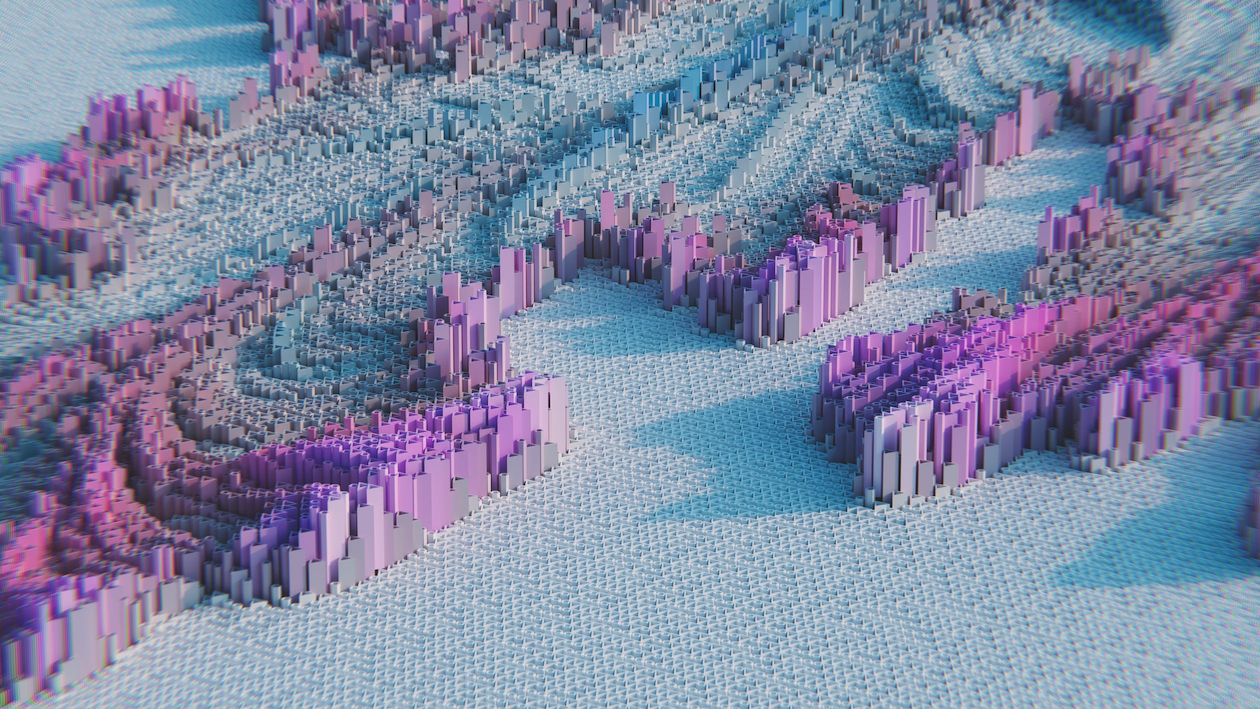

## Disclaimer

-----------------------------------------------------------------------------------------
**This data science notebook is provided for educational purposes only.**

It contains code, analysis, and models that are intended to serve as learning materials and examples. The content is not intended for direct deployment to production environments.

You are encouraged to adapt and modify the contents of this notebook in accordance with the license provided in the associated github repository. However, it is essential to exercise caution, further development, and thorough testing before considering any deployment to production systems.

The authors and contributors of this notebook assume no liability for any consequences, including financial or operational, resulting from the use or misuse of the information and code provided herein. Always consult with appropriate experts and conduct rigorous testing and validation before applying any techniques or models in a real-world, production context.

**By using this notebook, you agree to these terms and conditions.**

-----------------------------------------------------------------------------------------


## Content

PDF extraction is of paramount importance for financial supervisors due to the widespread use of PDF format in the financial industry. Financial supervisors have historically received a multitude of reports, statements, and documents in PDF form across various supervisory areas. However, the critical data contained within these files often remains locked away, making it challenging to analyze, monitor, and ensure compliance.

PDF extraction technology empowers financial supervisors to efficiently unlock and extract vital information from these documents. This capability not only streamlines data processing but also enhances regulatory oversight, risk management, and decision-making processes, ultimately ensuring the integrity and transparency of the financial sector.

## Resources and acknowledgements

The work on table extractions were based entirely on the camelot library's [excellent online documentation](https://camelot-py.readthedocs.io/en/master/index.html), including their [comparison with tabula-py and other similar libraries](https://github.com/camelot-dev/camelot/wiki/Comparison-with-other-PDF-Table-Extraction-libraries-and-tools)

The pdf for our "mobile money tarriff extraction" case study was [publicly available online](https://www.airtel.co.zm/assets/pdf/AIRTEL-Tariff-Guide-Poster-A1.pdf) on Airtel's website.

The dataset for our "quarterly statements extraction" case study was also [publicly available online](https://www.bayer.com/sites/default/files/2023-05/bayer-quarterly-statement-q1-2023.pdf) on Bayer's website.

Both were saved to a public location on Google Drive for the sake of continuity of this notebook.

## Defining our target

First we will consider two typical scenarios where financial supervisors need to delve into:

1. Mobile money tariff sheet table

  Extracting data from a mobile money tariff sheet enables market conduct supervisors to closely monitor pricing structures, transaction fees, and customer charges, ensuring fair practices within the mobile financial services sector.

2. Quarterly financial statement

  Extracting information from quarterly financial statements allows supervisors to gauge the financial health of institutions, assess risk exposure, and track compliance with capital adequacy requirements.

The process and tools involved in extracting text from these documents encompass a wide range of functionalities that hold substantial relevance for numerous supervisory use cases. Together, these examples highlight the versatility of PDF extraction tools in addressing the multifaceted data needs of financial supervisors across diverse domains.

Finally, we will review how some of this technology looks under the hood, and some tools to explore independently that can help with more advanced cases such as extracting from files that are not text-based, such as those that have been printed and scanned. For this purpose we’ve added a third piece of data:

3.	Prospectus

  Extracting information from a printed and scanned prospectus sheet allows supervisors to monitor the fees being presented as part of the offering, and compare against actuals and reported figures to test compliance.



## Installing and importing libraries

In [ ]:
##################################
# Helper libraries and functions #
##################################

# Web requests and files
import urllib
import requests
import io

# General data manipulation
import numpy as np
import pandas as pd

#################################
# For text-based pdf extraction #
#################################
import camelot

##################################
# For image-based pdf extraction #
##################################

# For pdf import and extraction of image-based pages
# The pymupdf library is called "fitz" for legacy reasons
import fitz

# Computer vision tools
import cv2
from imutils import contours
from google.colab.patches import cv2_imshow

# OCR tools
import pytesseract

# Case 1: Automating extraction from indexed pdf

In this case, we will be taking a look at the following:

* Extracting structured data (tables) using `camelot-py`
* Extracting & parsing unstructured data (text) using `PyMuPDF`

As an optional further exercise, you can also refer to the M2.2 in the Lab's Data Gymnasium for a deeper dive into how to the outputs of unstructured data to observe trends, sentiments, and topics

## Mobile Money Tariffs

### Getting the data

In [ ]:
# Airtel Tariffs
# From: https://www.airtel.co.zm/assets/pdf/AIRTEL-Tariff-Guide-Poster-A1.pdf
# Saved on 7 Oct
file = 'https://storage.googleapis.com/suptech-lab-practical-data-science-public/AIRTEL-Tariff-Guide-Poster-A1.pdf'
pages = '1'

tables = camelot.read_pdf(file, pages=pages, flavor='stream')

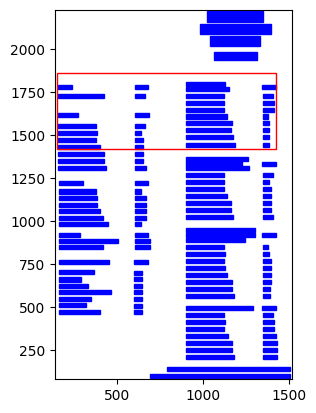

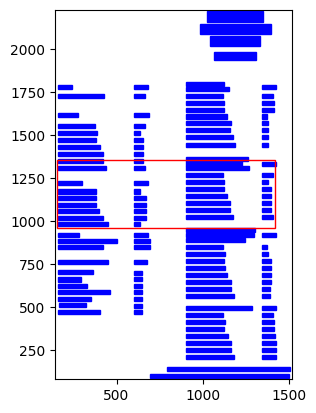

In [ ]:
for table in tables:
  camelot.plot(table, kind='contour').show()

### Preprocessing the data

In [ ]:
corners = [
    # First column
    '0,1850,750,1650',
    '0,1650,750,1260',
    '0,1260,750,950',
    '0,950,750,800',
    '0,800,750,400',

    # Second column
    '750,1850,1500,1400',
    '750,1400,1500,980',
    '750,980,1500,550',
    '750,550,1500,150'
]
tables = camelot.read_pdf(file, pages=pages, flavor='stream', table_areas=corners)

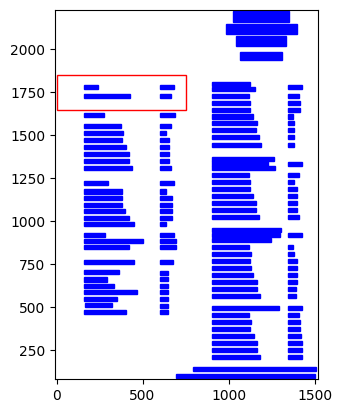

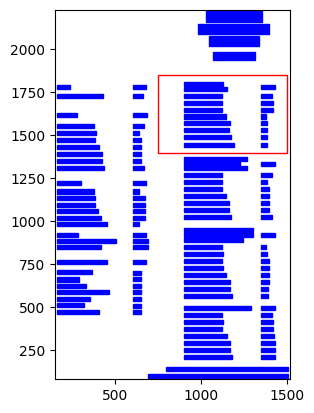

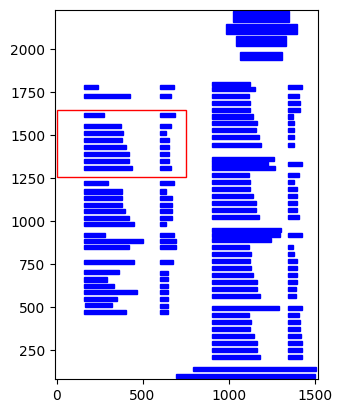

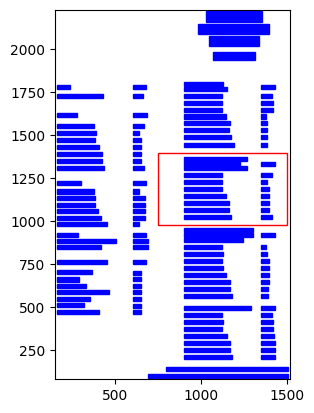

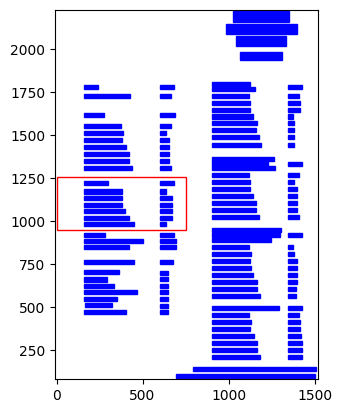

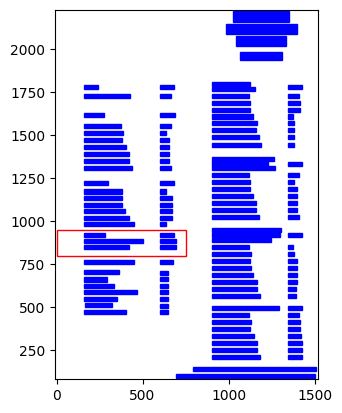

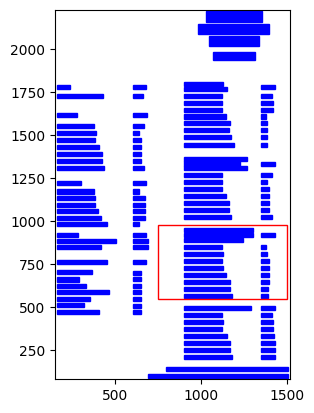

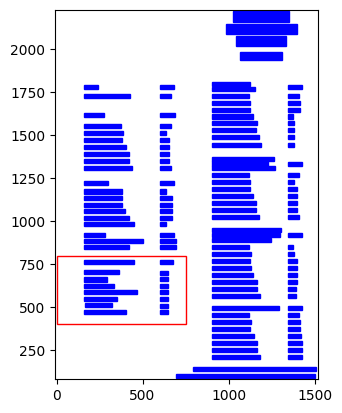

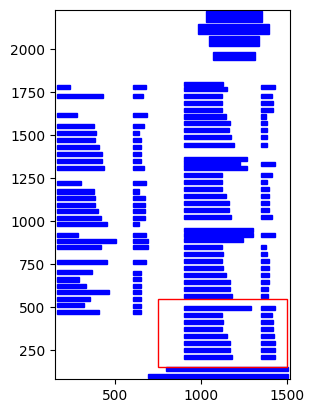

In [ ]:
for table in tables:
  camelot.plot(table, kind='contour').show()

### Evaluating our approach

In [ ]:
dfs = []
for table in tables:
    df = table.df
    df.columns = df.iloc[0]  # use first row as header
    df = df[1:]  # remove the first row from the dataframe
    dfs.append(df)

dfs[2]

0                Withdrawal Charge
1        Between K1 to K150  K2.50
2       Above  K150 to K300     K5
3        Above K300 to K500    K10
4     Above  K500 to K1,000    K20
5    Above K1,000 to K3,000    K30
6    Above K3,000 to K5,000    K50
7  Above  K5,000 to K10,000   K100

## Quarterly Statements

### Getting the data

In [ ]:
# Bayer quarterly statements
# From https://www.jpmorganchase.com/content/dam/jpmc/jpmorgan-chase-and-co/investor-relations/documents/quarterly-earnings/2023/2nd-quarter/fc5019d6-4433-4a61-a340-a9cb89c4c7e1.pdf
# Saved on 7 Oct 2023
file = 'https://storage.googleapis.com/suptech-lab-practical-data-science-public/jpmc-quarterly-statement.pdf'
pages = '2'

corners = [
    '0,640,600,460',
]

# flag_size because the document contains some superscripts: https://camelot-py.readthedocs.io/en/master/user/advanced.html#flag-superscripts-and-subscripts
tables = camelot.read_pdf(file, pages=pages, flavor='stream', table_areas=corners, flag_size=True)

### Processing the data

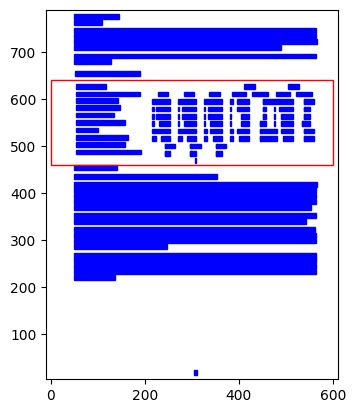

In [ ]:
camelot.plot(tables[0], kind='contour').show()

### Evaluating our approach

In [ ]:
dfs = []
for table in tables:
    df = table.df
    df.columns = df.iloc[0]  # use first row as header
    df = df[1:]  # remove the first row from the dataframe
    dfs.append(df)

dfs[0]

0                       Results for JPM                                    \
1   ($ millions, except per share data)      2Q23      1Q23       2Q22      
2                Net revenue - reported                                     
3                                        $ 41,307  $ 38,349   $ 30,715  $   
4                 Net revenue - managed                                     
5                                          42,401    39,336     31,630      
6                   Noninterest expense                                     
7                                          20,822    20,107     18,749      
8           Provision for credit losses                                     
9                                           2,899     2,275      1,101      
10                           Net income                                     
11                                       $ 14,472  $ 12,622  $ \n8,649  $   
12         Earnings per share - diluted                                     
13                                       $ \n4.75  $ \n4.10   $ \n2.76  $   
14              Return on common equity                                     
15                                           20 %      18 %       13 %      
16     Return on tangible common equity                                     
17                                             25        23         17      

0      1Q23              2Q22           
1   $ O/(U)  O/(U) %\n$ O/(U)  O/(U) %  
2                                       
3     2,958     8 % $  10,592     34 %  
4                                       
5     3,065     8 \n \n10,771       34  
6                                       
7       715      4 \n \n2,073       11  
8                                       
9       624     27 \n \n1,798      163  
10                                      
11    1,850    15 % $ \n5,823     67 %  
12                                      
13     0.65     16 % $ \n1.99     72 %  
14                                      
15                                      
16                                      
17

Fine tuning the columns, characters, and rows:

In [ ]:
# x-coordinates of the boundaries between columns
col_xs = ['200,260,320,370,430,480,530']

# Grab the header first, including special characters
tables = camelot.read_pdf(file, pages=pages, flavor='stream', table_areas=corners,
                          row_tol=10, columns=col_xs, flag_size=True)
df = tables[0].df

# Grab the table body with special characters removed
tables = camelot.read_pdf(file, pages=pages, flavor='stream', table_areas=corners,
                          row_tol=10, columns=col_xs, strip_text=["\n","$","%"], flag_size=True, split_text=True)

df2 = tables[0].df
df2 = df2[2:] # remove the first rows from the dataframe, which we don't need
df2.columns = df.iloc[1] # set the column headers

df2

1 ($ millions, except per share data)    2Q23    1Q23    2Q22 $ O/(U) O/(U) %  \
2              Net revenue - reported  41,307  38,349  30,715   2,958       8   
3               Net revenue - managed  42,401  39,336  31,630   3,065       8   
4                 Noninterest expense  20,822  20,107  18,749     715       4   
5         Provision for credit losses   2,899   2,275   1,101     624      27   
6                          Net income  14,472  12,622   8,649   1,850      15   
7        Earnings per share - diluted    4.75    4.10    2.76    0.65      16   
8             Return on common equity      20      18      13                   
9    Return on tangible common equity      25      23      17                   

1 $ O/(U) O/(U) %  
2  10,592      34  
3  10,771      34  
4   2,073      11  
5   1,798     163  
6   5,823      67  
7    1.99      72  
8                  
9

# Case 2: Under the hood with extraction for unindexed pdfs

Liberating data from an unindexed pdf follows the general process:

* Converting to image ([PyMuPDF](https://pymupdf.readthedocs.io/en/latest/) to extact page as image)
* Identifiying tabular cells in image (https://stackoverflow.com/a/59619675)
* Converting cells to text (https://stackoverflow.com/questions/37745519/use-pytesseract-ocr-to-recognize-text-from-an-image)

Example video and library here: https://livefiredev.com/how-to-extract-table-from-image-in-python-opencv-ocr/

### Get the data

In [ ]:
# Load the pdf into our notebook
# From: https://www.marsicofunds.com/SiteFiles/Auth/documents/prospectus.pdf
# Printed and scanned to set up this example
# Saved on 7 Oct
request = requests.get("https://storage.googleapis.com/suptech-lab-practical-data-science-public/scanned-prospectus.pdf")
filestream = io.BytesIO(request.content)

### Preprocess the data

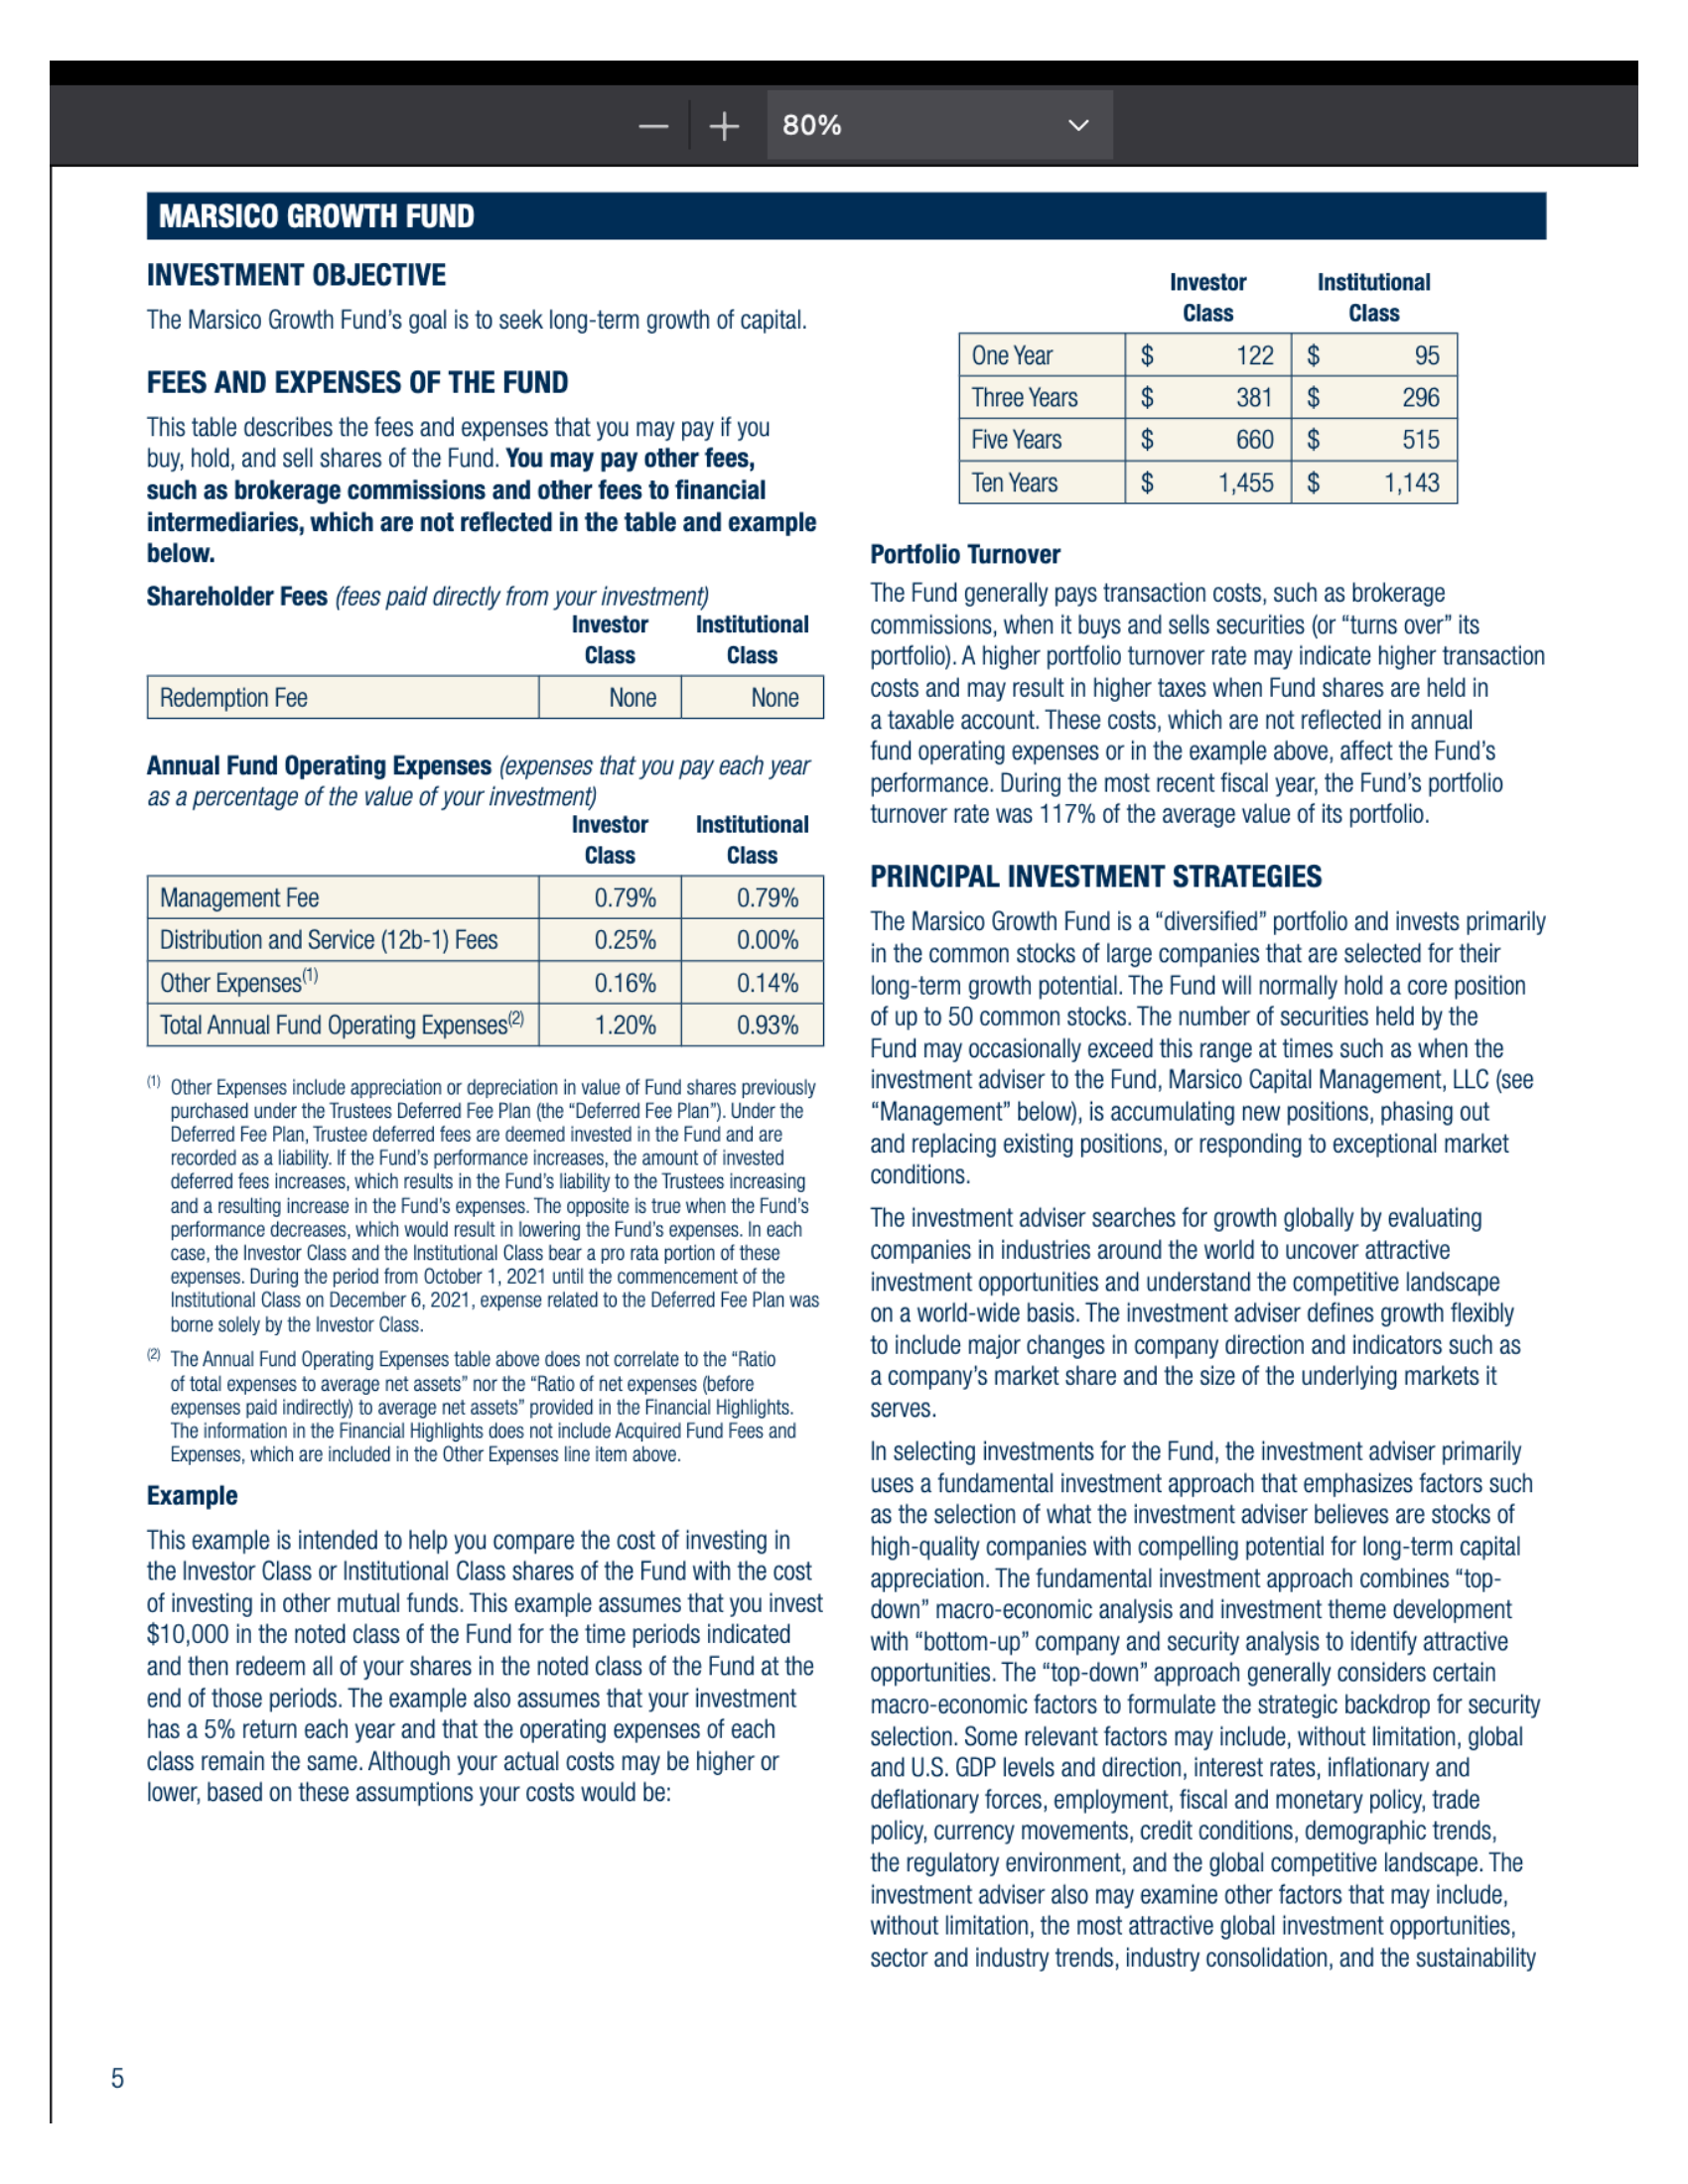

In [ ]:
# Open a stream of the file
pdf = fitz.open(stream=filestream, filetype="pdf")

# Get text contents of doc
pdf_contents = ""
for page in pdf:
  pdf_contents += page.get_text()

# Extract the page with the table that we want
page = pdf.load_page(0)  # number of page

# Convert the page to an image
pix = page.get_pixmap(dpi=200) # pay attention to dpi as part of streaming!
pix.save('table.png')

# Close the stream of the file
pdf.close()

cv2_imshow(cv2.imread('table.png'))

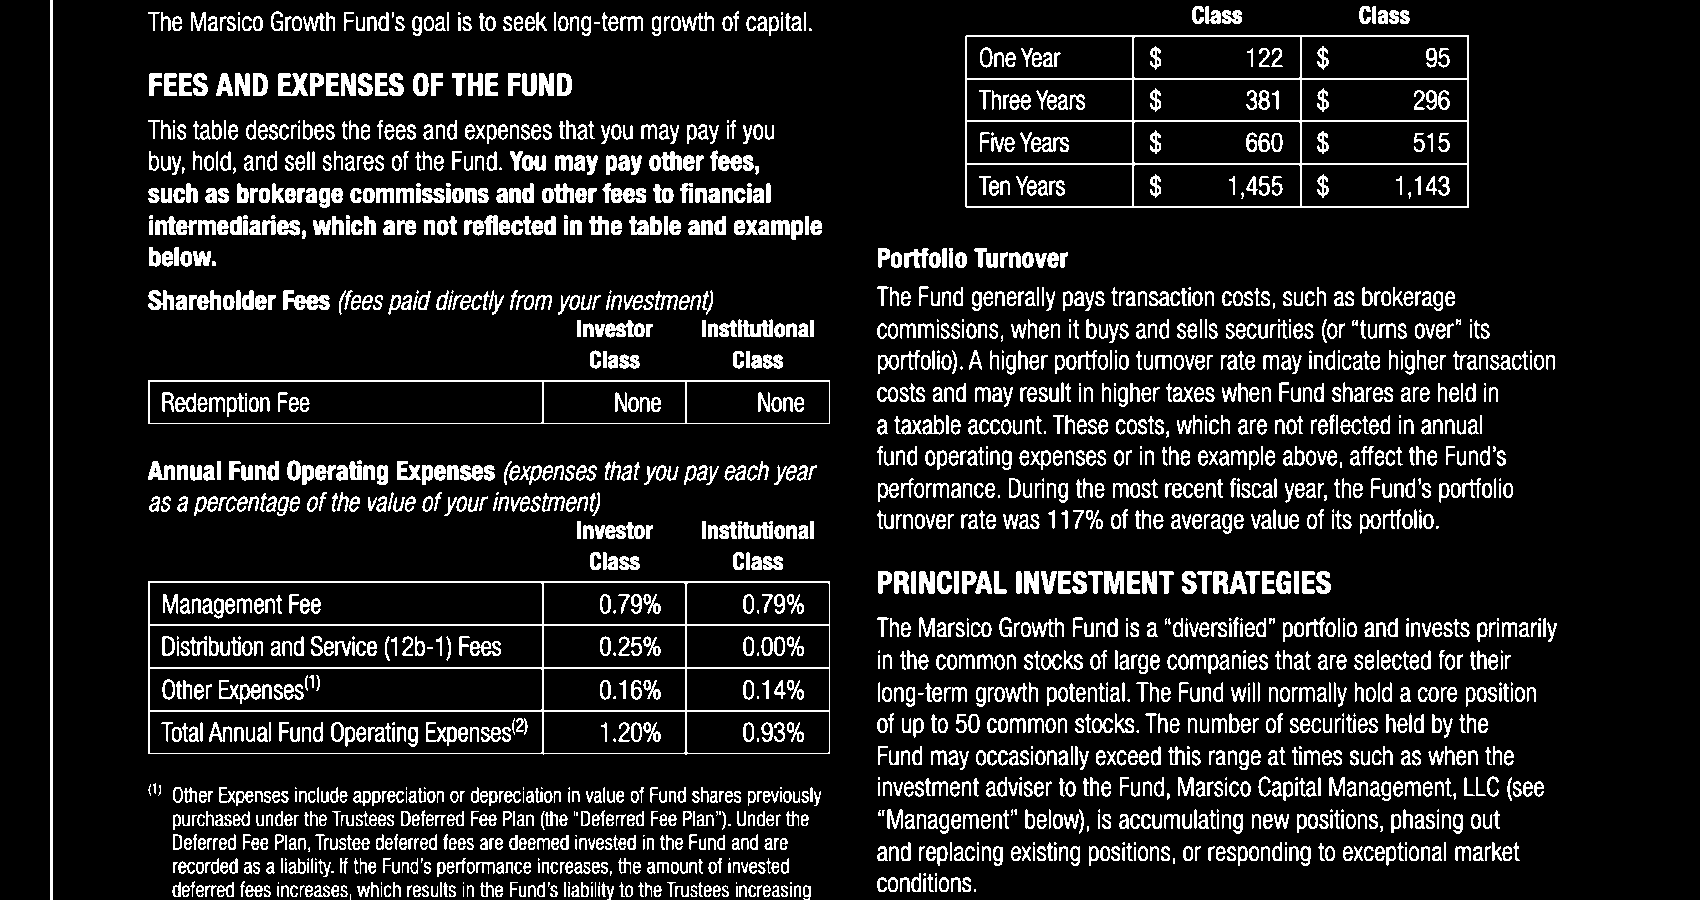

In [ ]:
# Load image, grayscale, Otsu's threshold

# For local file
image = cv2.imread('table.png')

# Crop the top and bottom
height, width, channels = image.shape
crop_img = image[300:height-1000, 0:width]

original = crop_img.copy()
gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

cv2_imshow(thresh)

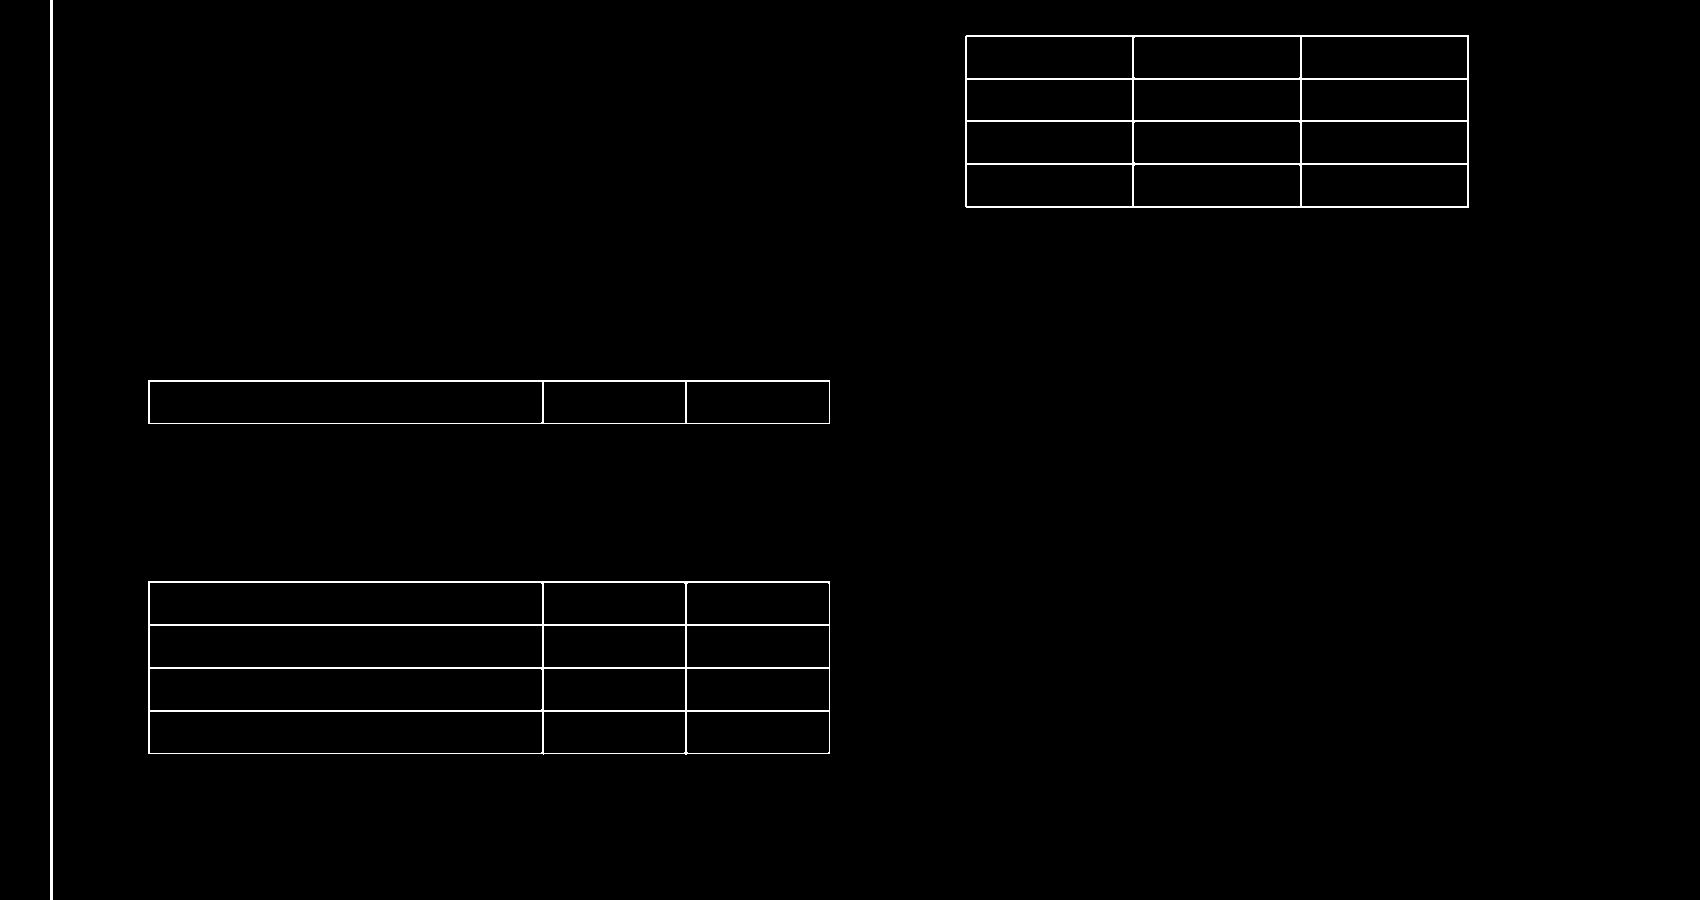

In [ ]:
# Remove text characters with morph open and contour filtering
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 500:
        cv2.drawContours(opening, [c], -1, (0,0,0), -1)

cv2_imshow(opening)

### Set up our model

In [ ]:
# Repair table lines, sort contours, and extract ROI
close = 255 - cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
cnts = cv2.findContours(close, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

## Test our model

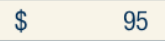

$ 95



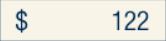

$ 122



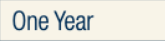

One Year



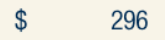

$ 296



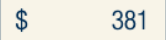

$ 381



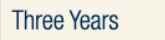

Three Years



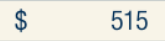

$ 515



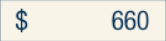

$ 660



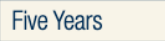

Five Years



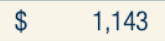

$ 1,143



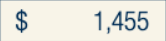

$ 1,465



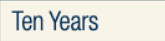

Ten Years



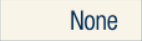

None



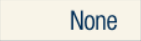

None



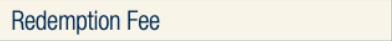

Redemption Fee



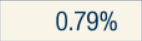

0.79%



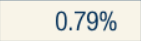

0.79%



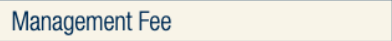

Management Fee



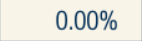

0.00%



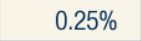

0.25%



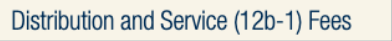

Distribution and Service (12b-1) Fees



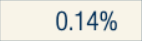

0.14%



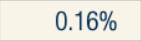

0.16%



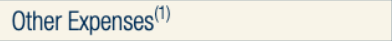

Other Expenses



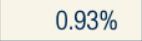

0.93%



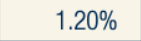

1.20%



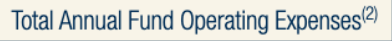

Total Annual Fund Operating Expenses



In [ ]:
for c in cnts:
    area = cv2.contourArea(c)
    if area < 25000:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), -1)
        ROI = thresh[y:y+h, x:x+w] # Region Of Interest
        ROItoconvert = 255 - ROI

        # Visualization
        cv2_imshow(original[y:y+h, x:x+w])
        cv2.waitKey(20)
        data = pytesseract.image_to_string(ROItoconvert, lang='eng', config='--psm 10 -c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ$.%()-,\ ')
        print(data)

# Areas for further exploration

* Improve the classification of the extracted cells using, e.g., convolutional neural networks instead of py-tesseract library
* Add in support for handwritten digits